# Computed Tomography Analysis using DL

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL as pl
import os
import pandas as pd
import time
import random

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout, RandomBrightness, RandomFlip
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

2024-06-02 15:50:05.522031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 15:50:05.522130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 15:50:05.626198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!nvidia-smi

Sun Jun  2 15:50:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

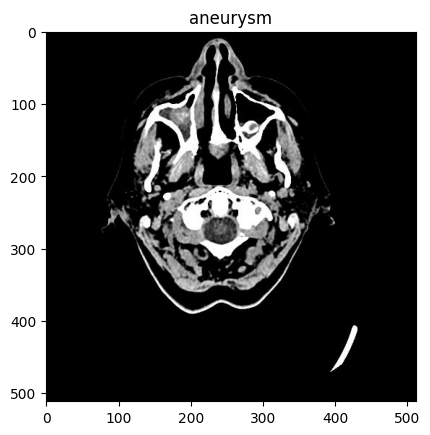

In [3]:
img = cv2.imread("/kaggle/input/gssoc-ct-augumented-ds/files/aneurysm/10.jpg")
plt.title('aneurysm')
plt.imshow(img, label = 'aneurysm')
plt.show()

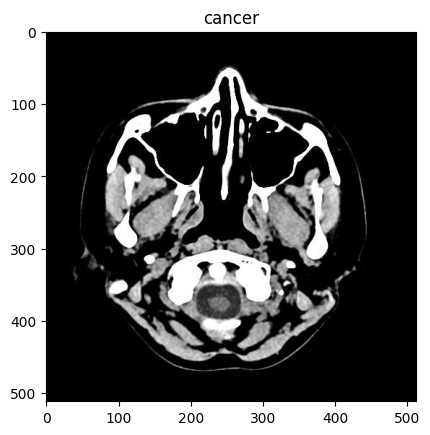

In [4]:
img = cv2.imread("/kaggle/input/gssoc-ct-augumented-ds/files/cancer/20.jpg")
plt.title('cancer')
plt.imshow(img, label = 'cancer')
plt.show()

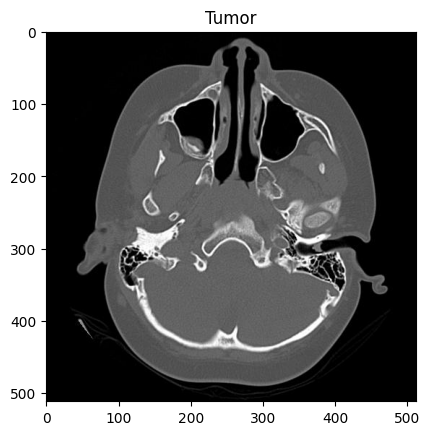

In [5]:
img = cv2.imread("/kaggle/input/gssoc-ct-augumented-ds/files/tumor/10.jpg")
plt.title('Tumor')
plt.imshow(img, label = 'Tumor Case')
plt.show()

## EDA

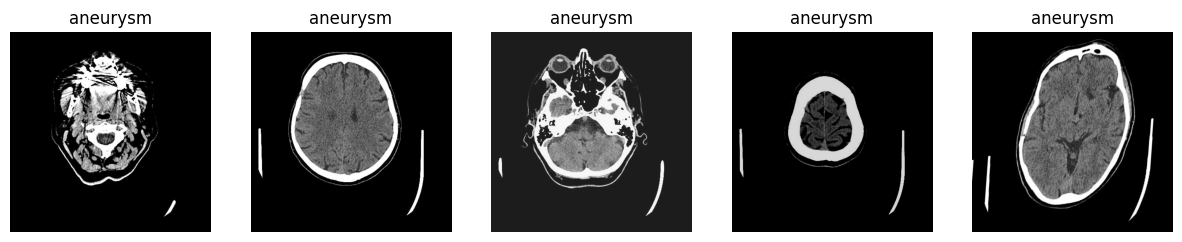

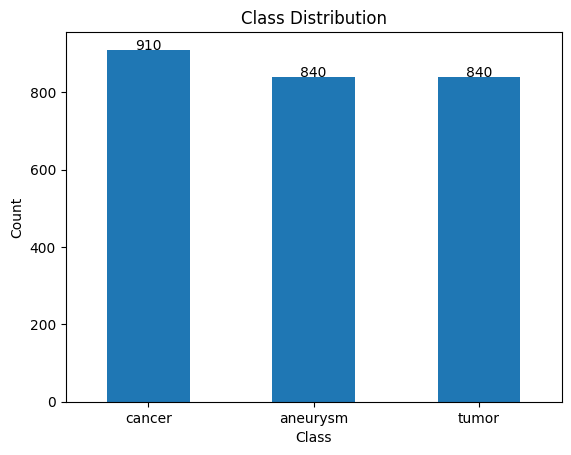

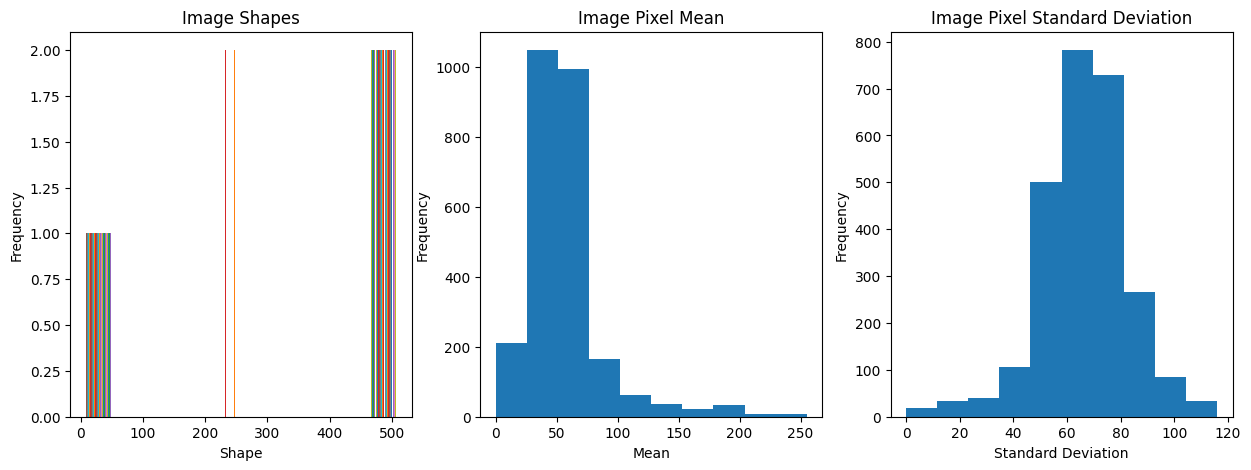

In [6]:

def load_image(file_path):
    """
    Load an image from file.

    Args:
    - file_path: Path to the image file.

    Returns:
    - img: Loaded image as a numpy array.
    """
    img = cv2.imread(file_path)
    return img

def display_sample_images(image_paths, labels, num_samples=5):
    """
    Display sample images from the dataset.

    Args:
    - image_paths: List of paths to image files.
    - labels: List of corresponding labels for the images.
    - num_samples: Number of sample images to display (default: 5).
    """
    buff = 0
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(5):
        img_path = os.path.join('/kaggle/input/gssoc-ct-augumented-ds/files', image_paths[i+buff])
        img = cv2.imread(img_path)
        if img is not None:
            # print("Image Loaded Successfully.")
            # print("Image dtype:", img.dtype)
            axes[i].imshow(img)
            axes[i].set_title(labels[i+buff])
            axes[i].axis('off')
        else:
            print("Error: Unable to load image.")
        buff += 50
    plt.show()


def plot_class_distribution(labels):
    """
    Plot the distribution of classes in the dataset.

    Args:
    - labels: List of class labels.
    """
    class_counts = pd.Series(labels).value_counts()
    class_counts.plot(kind='bar', rot=0)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')

    # Add counts over bars
    for i, count in enumerate(class_counts):
        plt.text(i, count + 0.1, str(count), ha='center')

    plt.show()

def visualize_image_statistics(images):
    """
    Visualize statistics of image data.

    Args:
    - images: List of image arrays.
    """
    image_shapes = [img.shape for img in images]
    image_means = [np.mean(img) for img in images]
    image_stds = [np.std(img) for img in images]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].hist(image_shapes)
    axes[0].set_title('Image Shapes')
    axes[0].set_xlabel('Shape')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(image_means)
    axes[1].set_title('Image Pixel Mean')
    axes[1].set_xlabel('Mean')
    axes[1].set_ylabel('Frequency')

    axes[2].hist(image_stds)
    axes[2].set_title('Image Pixel Standard Deviation')
    axes[2].set_xlabel('Standard Deviation')
    axes[2].set_ylabel('Frequency')

    plt.show()

def perform_eda(dataset_folder):
    """
    Perform exploratory data analysis (EDA) on the image dataset.

    Args:
    - dataset_folder: Path to the dataset folder containing image files.
    """
    # Load dataset information from .csv file
    dataset_info = pd.read_csv(os.path.join(dataset_folder, 'ct-brains-augmented.csv'))

    # Display sample images
    display_sample_images(dataset_info['jpg'], dataset_info['type'])

    # Plot class distribution
    plot_class_distribution(dataset_info['type'])

    # Load images and visualize image statistics
    images = []
    # print(dataset_info['jpg'])
    for file_path in dataset_info['jpg']:
        img = load_image(os.path.join('/kaggle/input/gssoc-ct-augumented-ds/files', file_path))
        images.append(img)
    visualize_image_statistics(images)

# Example usage:
dataset_folder = r"/kaggle/input/gssoc-ct-augumented-ds/files"
perform_eda(dataset_folder)



## Train-Test split

In [7]:

# Generate data paths with labels
def define_paths(dir):
    filepaths = []
    labels = []

    classes = os.listdir(dir)
    for class_name in classes:
        if os.path.isdir(os.path.join(dir, class_name)):
            class_path = os.path.join(dir, class_name)
            filelist = os.listdir(class_path)
            for file in filelist:
                fpath = os.path.join(class_path, file)
                if fpath.endswith('.jpg'):
                    filepaths.append(fpath)
                    labels.append(class_name)
    return filepaths, labels


# Concatenate data paths with labels into one dataframe
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

# Split data into train, validation, and test
def split_data(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df, test_df = train_valid_test_split(df, train_size=0.6, valid_size=0.05, test_size=0.35, shuffle=True, random_state=123, stratify=strat)
    return train_df, valid_df, test_df

# Custom train, validation, test split function
def train_valid_test_split(df, train_size, valid_size, test_size, shuffle=True, random_state=None, stratify=None):
    assert train_size + valid_size + test_size == 1.0, "The sum of train_size, valid_size, and test_size should be 1.0"


    if shuffle:
        df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    num_samples = len(df)
    train_end = int(train_size * num_samples)
    valid_end = int((train_size + valid_size) * num_samples)

    train_df = df[:train_end]
    valid_df = df[train_end:valid_end]
    test_df = df[valid_end:]

#     return train_df, test_df
    return train_df, valid_df, test_df


# Get Dataframes
data_dir = r"/kaggle/input/gssoc-ct-augumented-ds/files"
# train_df, test_df = split_data(data_dir)
train_df, valid_df, test_df = split_data(data_dir)

# Display the head of each dataframe
print("Train Data:")
print(train_df.head())
print("")
print(train_df.tail())
print("")

print("Validation Data:")
print(valid_df.head())
print("")
print(valid_df.tail())
print("")

print("Test Data:")
print(test_df.head())
print("")
print(test_df.tail())

Train Data:
                                           filepaths    labels
0  /kaggle/input/gssoc-ct-augumented-ds/files/ane...  aneurysm
1  /kaggle/input/gssoc-ct-augumented-ds/files/can...    cancer
2  /kaggle/input/gssoc-ct-augumented-ds/files/can...    cancer
3  /kaggle/input/gssoc-ct-augumented-ds/files/ane...  aneurysm
4  /kaggle/input/gssoc-ct-augumented-ds/files/can...    cancer

                                              filepaths    labels
1549  /kaggle/input/gssoc-ct-augumented-ds/files/ane...  aneurysm
1550  /kaggle/input/gssoc-ct-augumented-ds/files/ane...  aneurysm
1551  /kaggle/input/gssoc-ct-augumented-ds/files/can...    cancer
1552  /kaggle/input/gssoc-ct-augumented-ds/files/can...    cancer
1553  /kaggle/input/gssoc-ct-augumented-ds/files/ane...  aneurysm

Validation Data:
                                              filepaths    labels
1554  /kaggle/input/gssoc-ct-augumented-ds/files/ane...  aneurysm
1555  /kaggle/input/gssoc-ct-augumented-ds/files/can...    canc

In [8]:
print(train_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  1554 non-null   object
 1   labels     1554 non-null   object
dtypes: object(2)
memory usage: 24.4+ KB
None


In [9]:
print(valid_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 1554 to 1682
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  129 non-null    object
 1   labels     129 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB
None


In [10]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 1683 to 2589
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  907 non-null    object
 1   labels     907 non-null    object
dtypes: object(2)
memory usage: 14.3+ KB
None


In [11]:
def create_model_data (train_df, valid_df, test_df, batch_size):

    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes
         data from image data generator.
         Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                            color_mode= color, shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                                color_mode= color, shuffle= True, batch_size= batch_size)
    
    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                           color_mode= color, shuffle= False, batch_size= test_batch_size)

#     return train_gen, test_gen
    return train_gen, valid_gen, test_gen
Batch_size = 32
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, Batch_size)


Found 1554 validated image filenames belonging to 3 classes.
Found 129 validated image filenames belonging to 3 classes.
Found 907 validated image filenames belonging to 3 classes.


In [12]:
def show_images(gen):

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator


    # calculate number of dispalyed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)

        # note
        index = np.argmax(labels[i])  # get image index

        class_name = classes[index]   # get class of image

        plt.title(class_name, color= 'blue', fontsize= 8)
        plt.axis('off')
    plt.show()

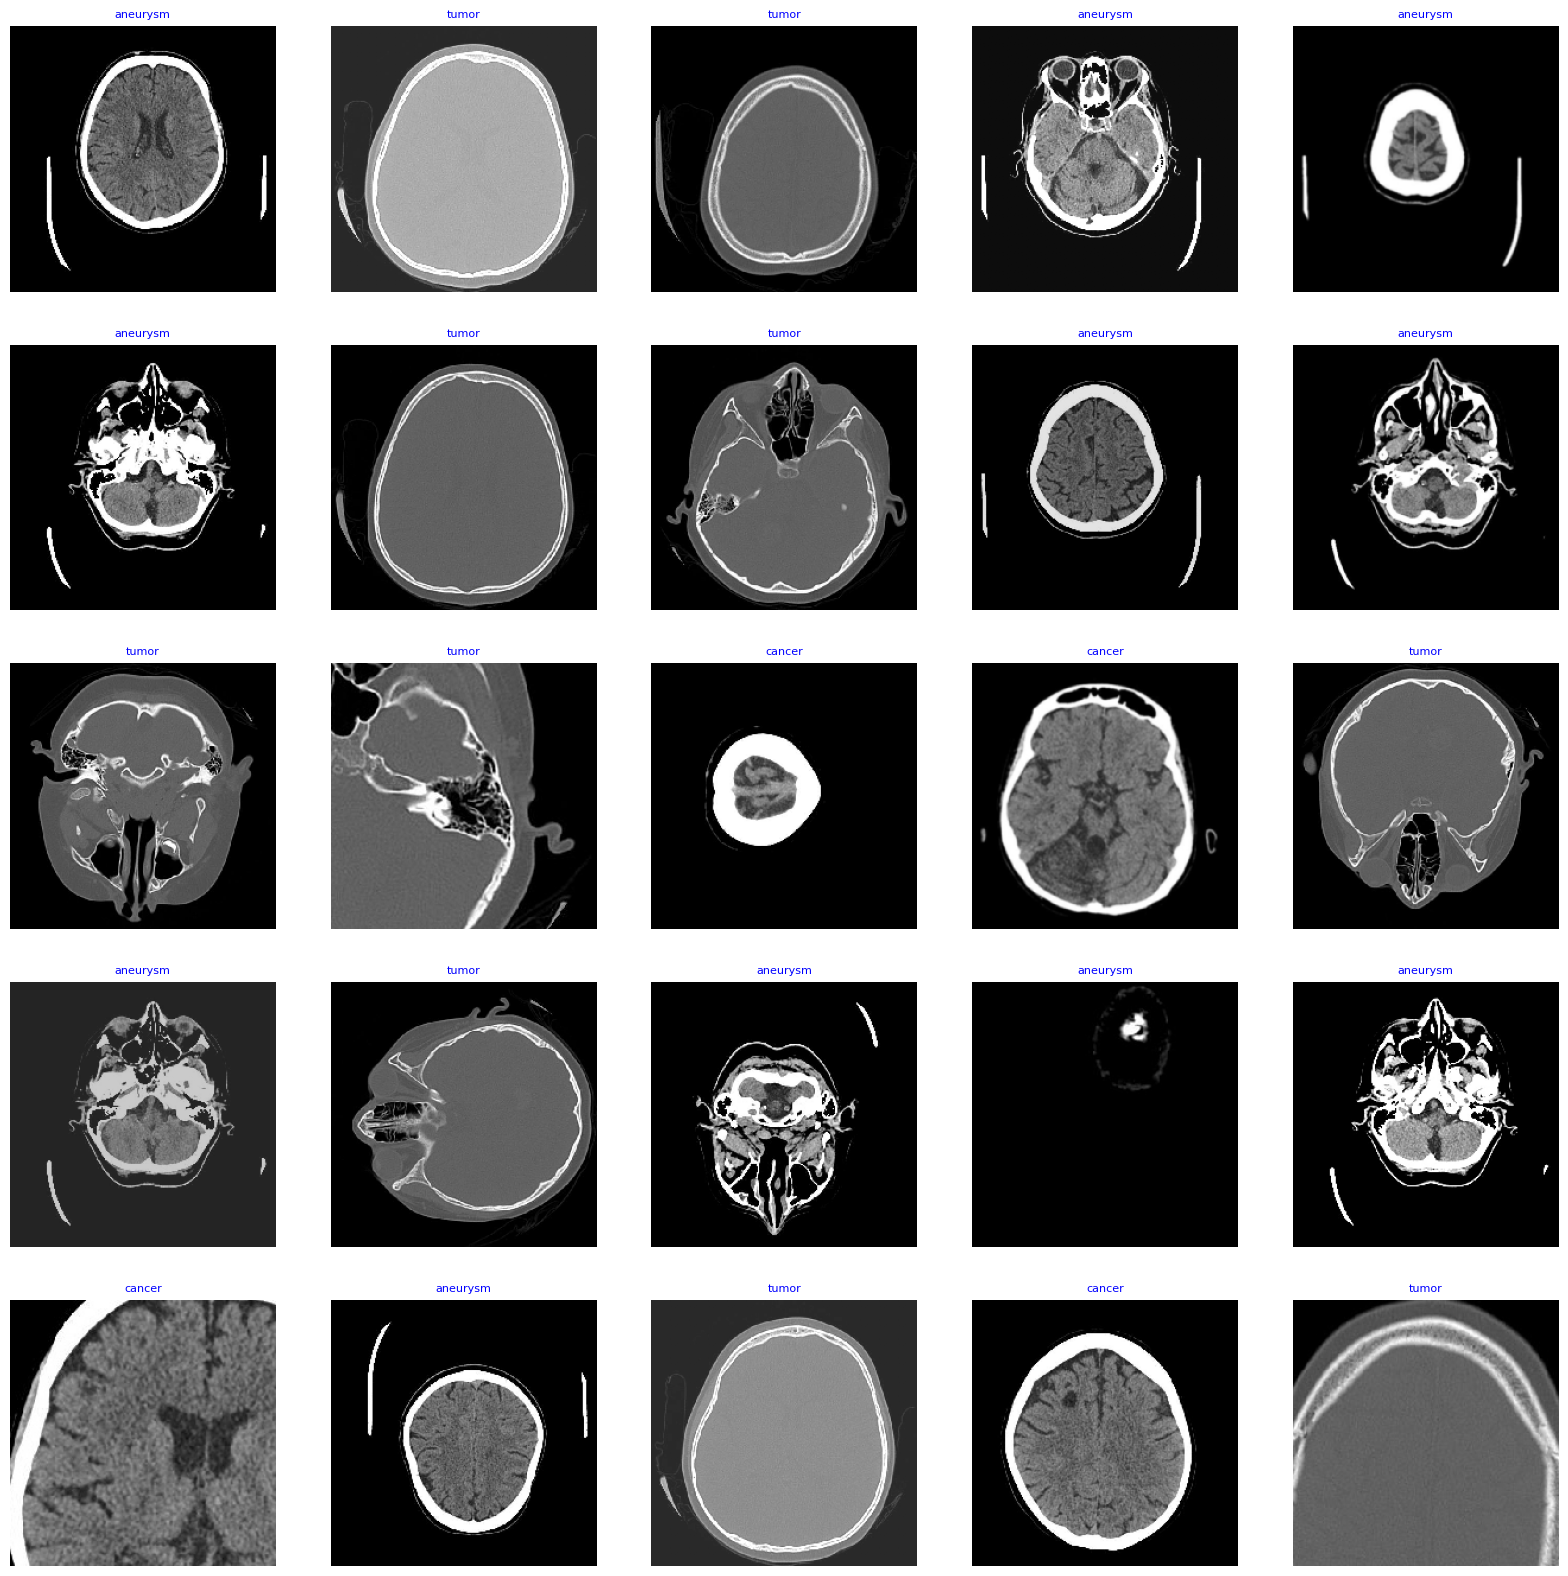

In [13]:
# Display Image Samples
show_images(train_gen)

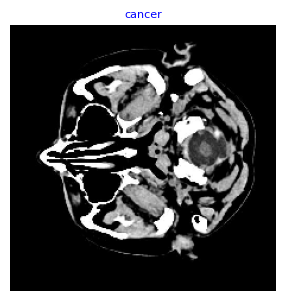

In [14]:
show_images(test_gen)

# Model Selection

## 1.VGG-16

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import L1L2

tf.keras.backend.clear_session()

# Load the VGG16 model without the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling = 'max')


# Freeze the pre-trained layers
# base_model.trainable = False

# Create a new model that includes the base_model
input_shape = (224, 224, 3)
vgg_model= tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (224,224, 3)),
#     tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    
    base_model,
    
    Dense(124, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),
    
    Dense(64, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(16, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(3, activation='softmax')
])

# Compile the model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(0.001),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)
vgg_model.summary()




58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
batch_size = 32  # set batch size for training
epochs = 90     # number of all epochs in training
patience = 1 		 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

# callbacks = [MyCallback(vgg_model, patience= patience,
#                         stop_patience= stop_patience, threshold= threshold, factor= factor,
#                         batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [18]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [19]:
history = vgg_model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=2,
    callbacks=[early_stopping],
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=True
)

Epoch 1/90


I0000 00:00:1717343588.187449      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717343588.211136      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717343657.466973      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717343671.113643      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 - 179s - 4s/step - accuracy: 0.3520 - auc: 0.5382 - loss: 5.8286 - precision: 0.3605 - recall: 0.2870 - val_accuracy: 0.3333 - val_auc: 0.5722 - val_loss: 7.8798 - val_precision: 0.3359 - val_recall: 0.3333
Epoch 2/90
49/49 - 23s - 473ms/step - accuracy: 0.3822 - auc: 0.5642 - loss: 5.6896 - precision: 0.3797 - recall: 0.2986 - val_accuracy: 0.3721 - val_auc: 0.5943 - val_loss: 5.6280 - val_precision: 0.4468 - val_recall: 0.3256
Epoch 3/90
49/49 - 23s - 474ms/step - accuracy: 0.4151 - auc: 0.5827 - loss: 5.6672 - precision: 0.4159 - recall: 0.3327 - val_accuracy: 0.3256 - val_auc: 0.6662 - val_loss: 5.2253 - val_precision: 0.4270 - val_recall: 0.2946
Epoch 4/90
49/49 - 23s - 469ms/step - accuracy: 0.4054 - auc: 0.5971 - loss: 5.6032 - precision: 0.4213 - recall: 0.3308 - val_accuracy: 0.4884 - val_auc: 0.7436 - val_loss: 5.1685 - val_precision: 0.5514 - val_recall: 0.4574
Epoch 5/90
49/49 - 23s - 466ms/step - accuracy: 0.4215 - auc: 0.6110 - loss: 5.5131 - precision: 0.4441 - rec

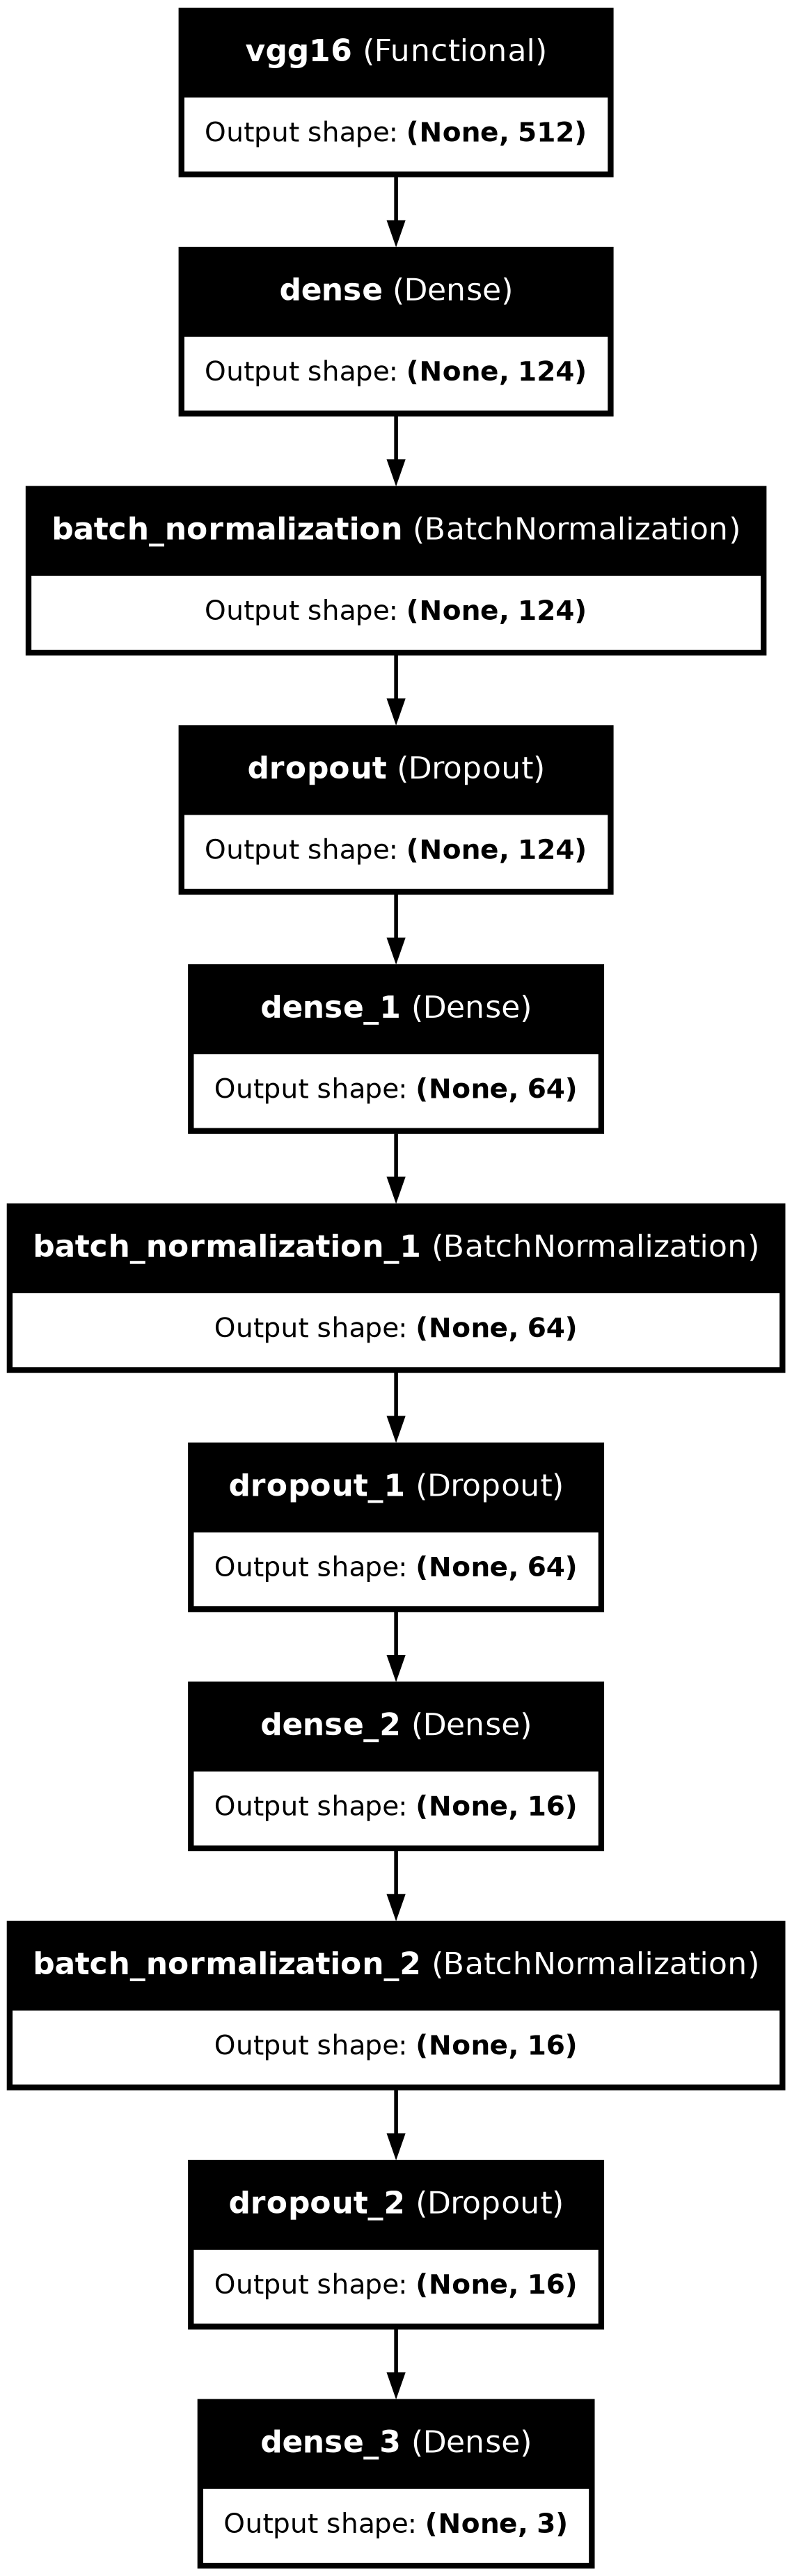

In [20]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
# Visualize the model architecture
plot_model(vgg_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

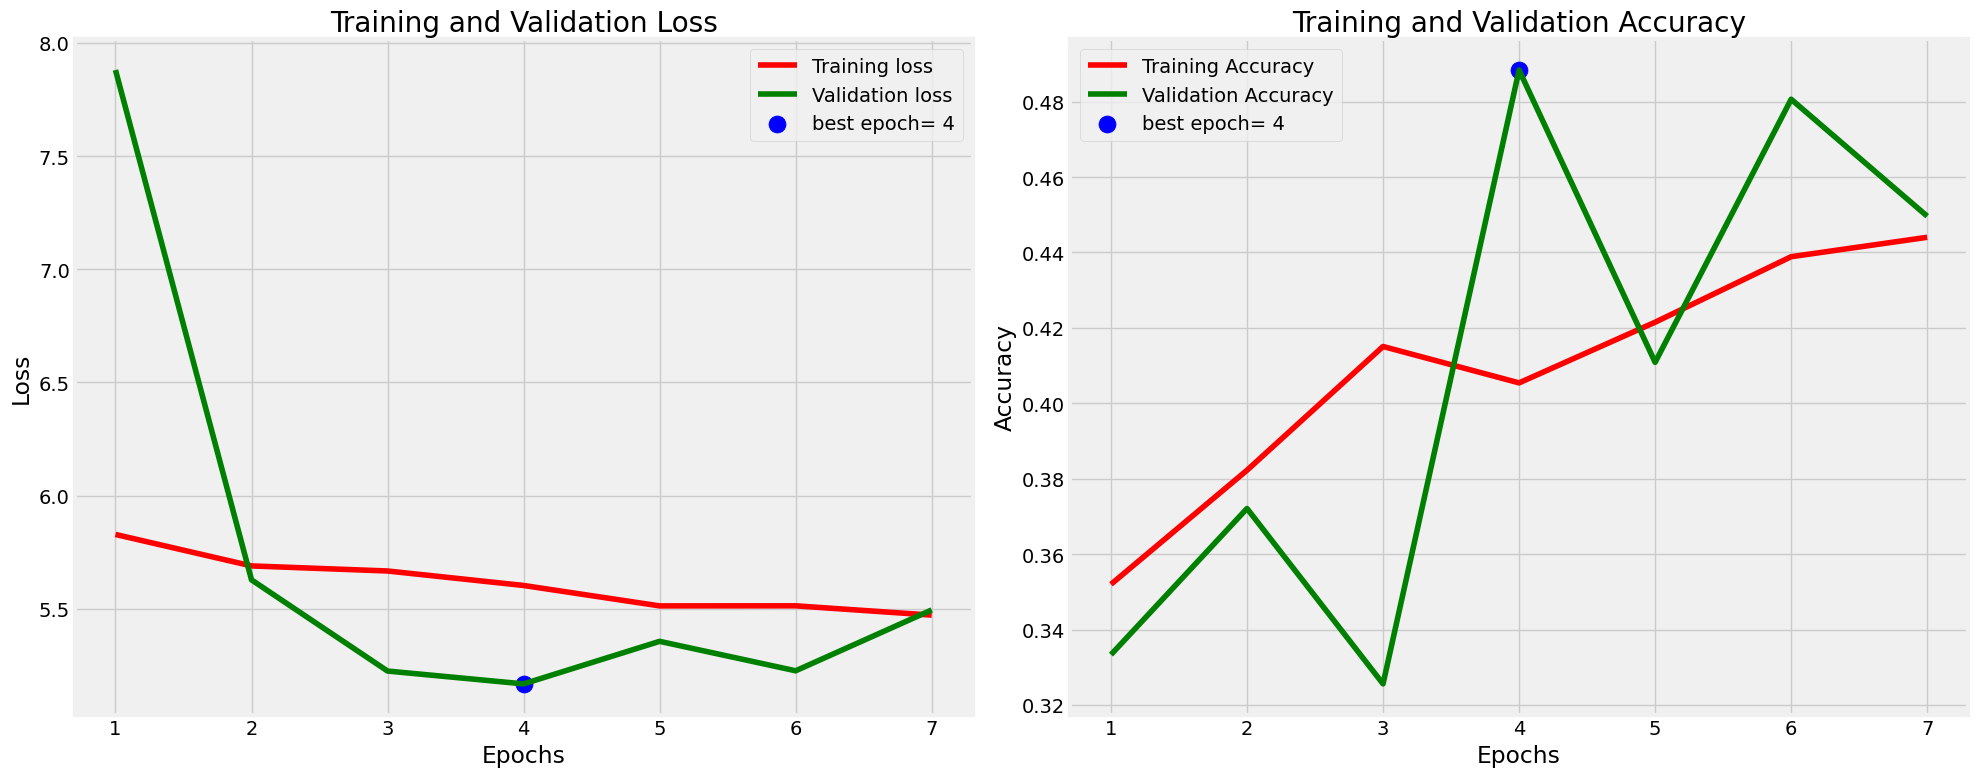

In [21]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    


    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_training(history)

In [22]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [23]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = vgg_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = vgg_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = vgg_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

907/907 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4765 - auc: 0.7020 - loss: 5.2213 - precision: 0.5229 - recall: 0.4465    


W0000 00:00:1717343823.553721      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.4884 - auc: 0.7437 - loss: 5.1684 - precision: 0.5515 - recall: 0.4575  
907/907 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5000 - auc: 0.7141 - loss: 5.2051 - precision: 0.5401 - recall: 0.4705
Train Loss:  5.221975326538086
Train Accuracy:  0.4761904776096344
--------------------
Validation Loss:  5.168546676635742
Validation Accuracy:  0.4883720874786377
--------------------
Test Loss:  5.197704792022705
Test Accuracy:  0.49393606185913086


In [24]:

preds = vgg_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)


907/907 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
[1 2 1 2 2 1 2 2 1 1 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 1 2 2 1 2 1 2 2 2 1 2 2 2 0 2 2
 1 1 1 2 1 2 2 2 1 1 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 1 2 2 1 2 1 1 2 2 1 2 1
 2 2 2 2 0 0 2 2 2 2 2 2 1 1 2 1 2 2 1 0 2 2 2 2 1 1 0 2 1 2 2 2 2 2 2 2 0
 2 2 2 1 2 2 1 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 2 2 2 2 1
 2 2 1 2 1 1 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 1 1
 2 1 1 1 2 1 2 2 2 1 2 1 2 2 2 2 2 2 2 2 1 2 0 2 2 1 1 1 2 2 2 2 2 2 2 2 1
 1 1 2 2 2 2 2 2 2 1 2 2 1 1 1 2 2 2 1 1 2 1 2 2 1 2 2 2 2 2 1 2 1 1 1 2 1
 1 2 2 1 2 2 1 2 1 2 1 2 1 2 2 2 2 2 2 1 1 2 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2
 1 2 1 2 2 2 2 2 2 1 2 2 2 1 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 2 1 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 2 1 2 2 1 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 1 2 1 2 2 1 1 2 2 2 1 2 2 2 2 2 1 2 1 2 1 2 2 

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

Confusion Matrix, Without Normalization
[[ 14 112 173]
 [  0 139 174]
 [  0   0 295]]
              precision    recall  f1-score   support

    aneurysm       1.00      0.05      0.09       299
      cancer       0.55      0.44      0.49       313
       tumor       0.46      1.00      0.63       295

    accuracy                           0.49       907
   macro avg       0.67      0.50      0.40       907
weighted avg       0.67      0.49      0.40       907



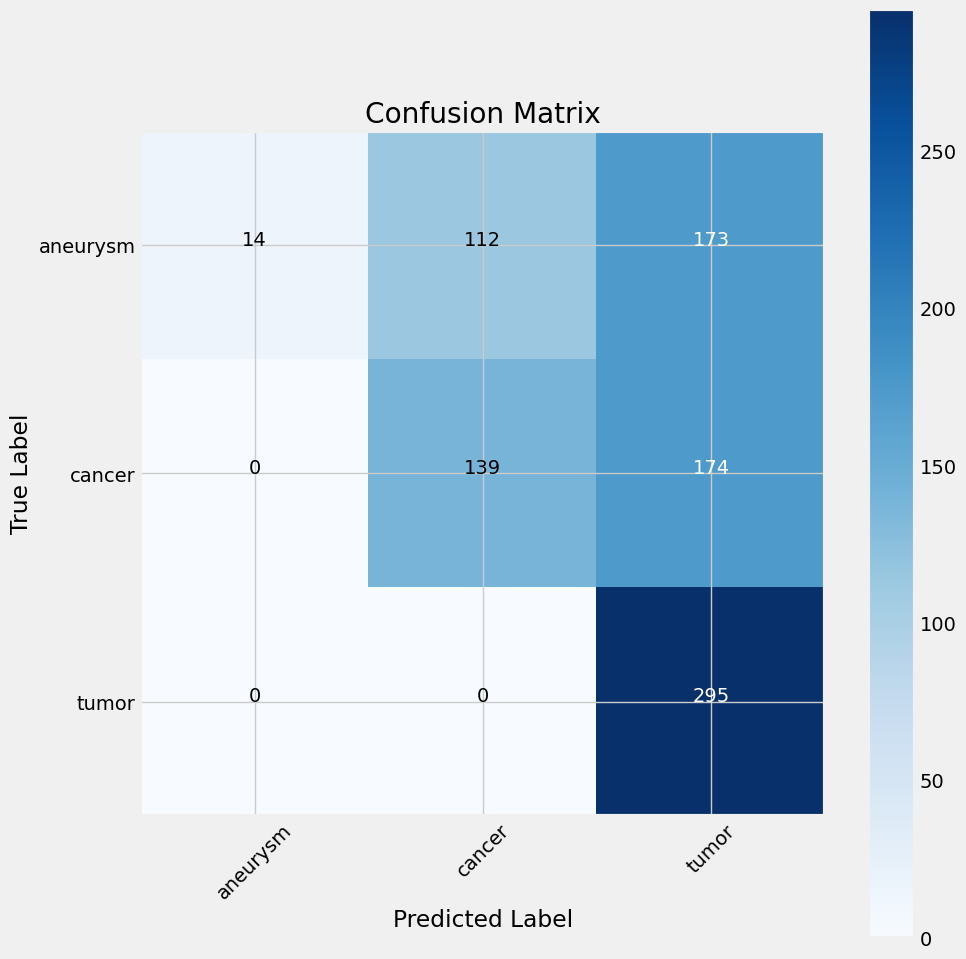

In [26]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

## 2. ResNet50

In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import L1L2

tf.keras.backend.clear_session()

# Load the VGG16 model without the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling = 'max')


# Freeze the pre-trained layers
base_model.trainable = True

# Create a new model that includes the base_model
input_shape = (224, 224, 3)
resnet_model= tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (224,224, 3)),
#     tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    
    base_model,
    
    Dense(128, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),
    
    Dense(64, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(16, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(3, activation='softmax')
])

# Compile the model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(0.001),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)
resnet_model.summary()





94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [28]:
batch_size = 32  # set batch size for training
epochs = 90     # number of all epochs in training
patience = 1 		 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

# callbacks = [MyCallback(model= resnet_model, patience= patience,
#                         stop_patience= stop_patience, threshold= threshold, factor= factor,
#                         batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [29]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [30]:
history2 = resnet_model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=2,
    callbacks=[early_stopping],
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=True
)

Epoch 1/90


W0000 00:00:1717343902.689283      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717343947.109397      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717343956.782977      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 - 116s - 2s/step - accuracy: 0.4524 - auc: 0.6397 - loss: 9.5259 - precision: 0.4738 - recall: 0.4015 - val_accuracy: 0.5116 - val_auc: 0.7108 - val_loss: 9.0905 - val_precision: 0.5053 - val_recall: 0.3721
Epoch 2/90
49/49 - 17s - 352ms/step - accuracy: 0.5920 - auc: 0.7637 - loss: 9.1161 - precision: 0.6143 - recall: 0.5257 - val_accuracy: 0.7752 - val_auc: 0.9002 - val_loss: 8.6983 - val_precision: 0.8378 - val_recall: 0.7209
Epoch 3/90
49/49 - 17s - 349ms/step - accuracy: 0.6486 - auc: 0.8211 - loss: 8.9411 - precision: 0.6904 - recall: 0.6113 - val_accuracy: 0.8140 - val_auc: 0.9492 - val_loss: 8.5415 - val_precision: 0.8547 - val_recall: 0.7752
Epoch 4/90
49/49 - 16s - 334ms/step - accuracy: 0.6956 - auc: 0.8627 - loss: 8.7977 - precision: 0.7355 - recall: 0.6551 - val_accuracy: 0.8450 - val_auc: 0.9702 - val_loss: 8.4396 - val_precision: 0.9027 - val_recall: 0.7907
Epoch 5/90
49/49 - 16s - 329ms/step - accuracy: 0.7278 - auc: 0.8816 - loss: 8.7258 - precision: 0.7703 - rec

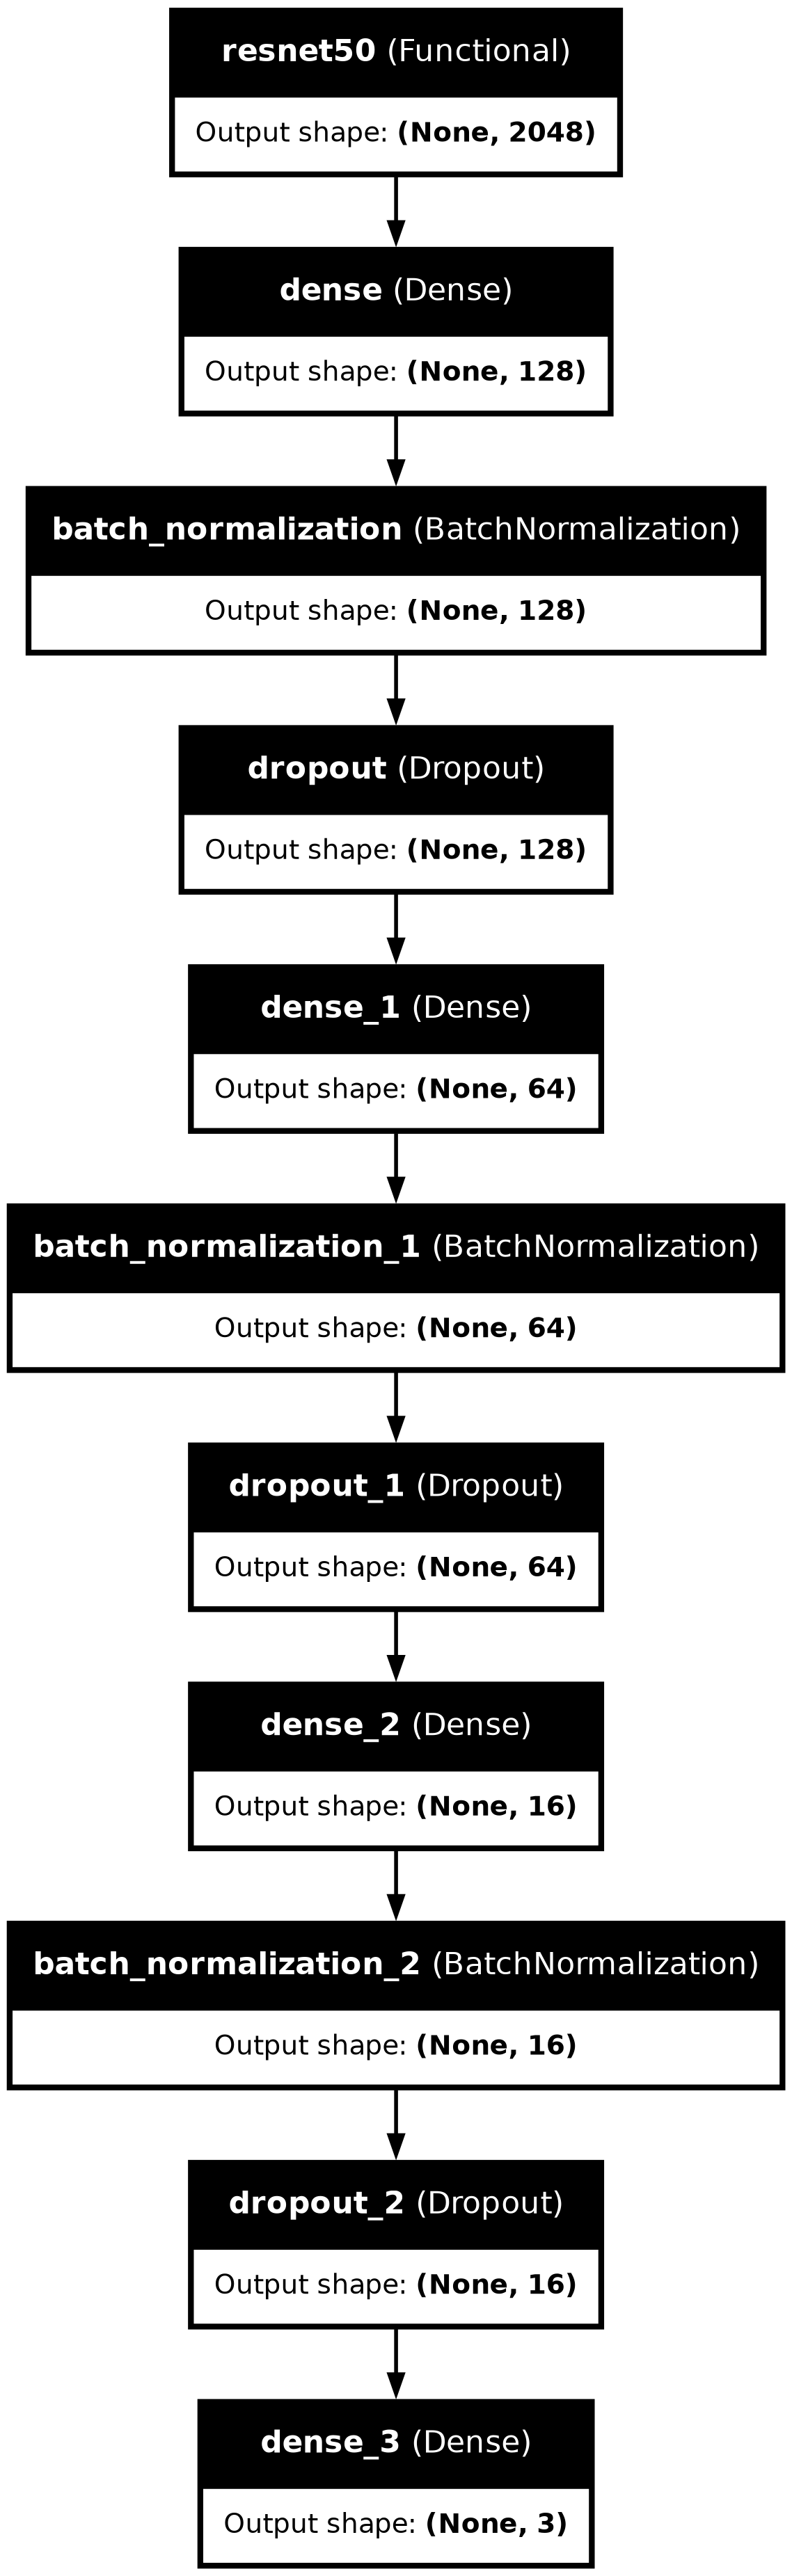

In [31]:
# Visualize the model architecture
plot_model(resnet_model, to_file='2nd-model_architecture.png', show_shapes=True, show_layer_names=True)

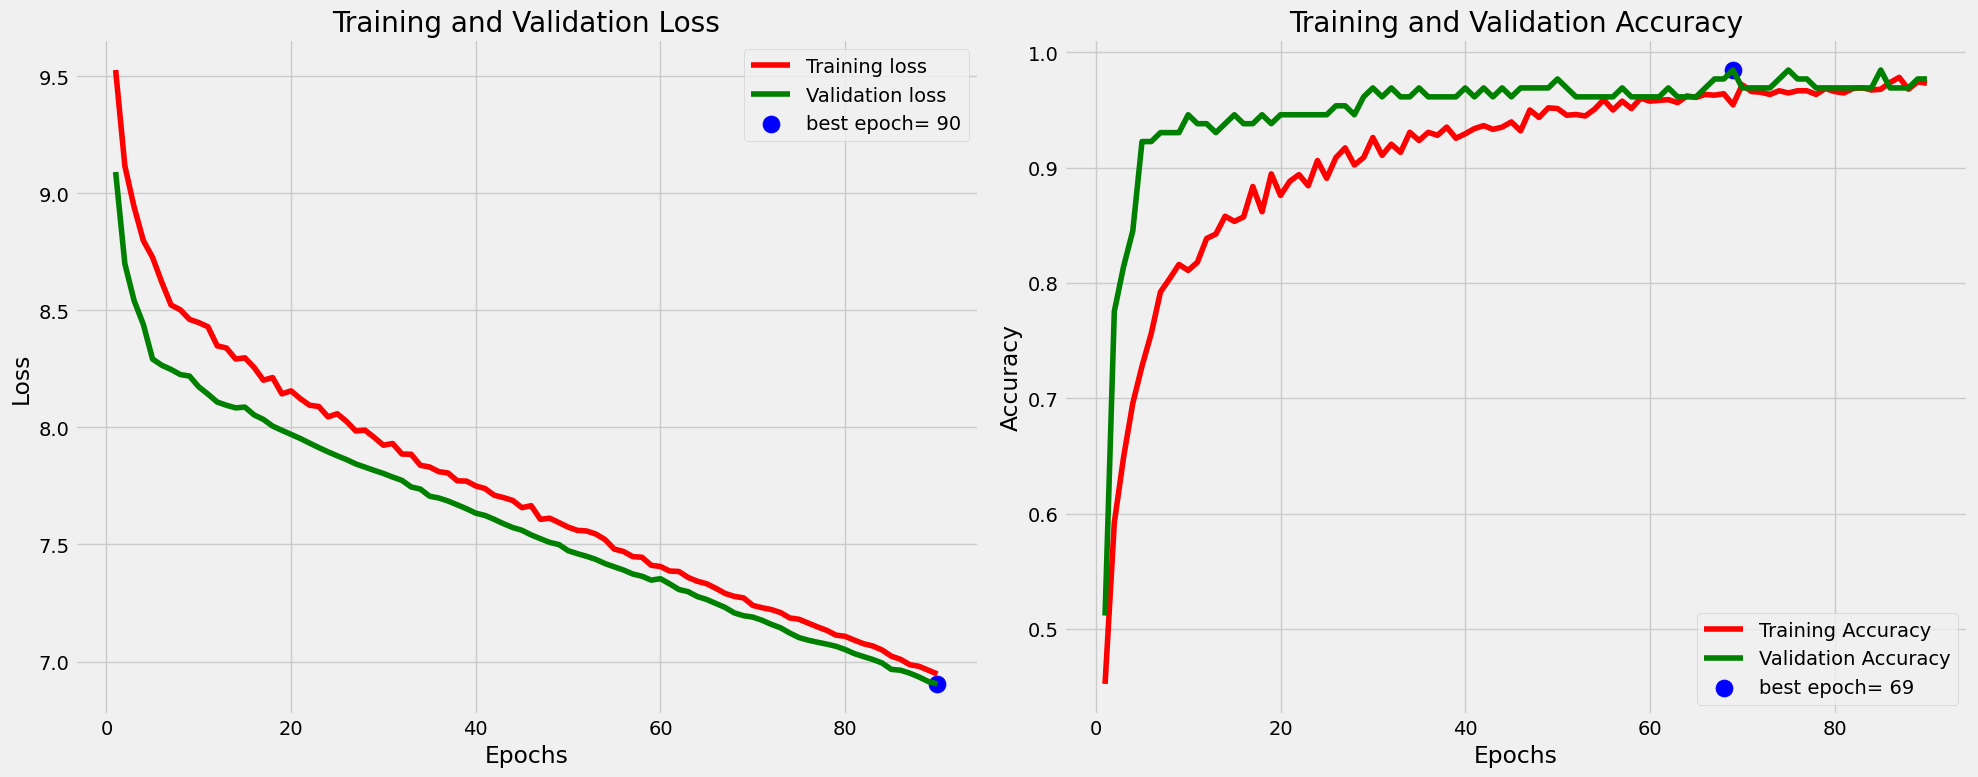

In [32]:
plot_training(history2)

In [33]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = resnet_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = resnet_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = resnet_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

907/907 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9937 - auc: 1.0000 - loss: 6.8498 - precision: 0.9937 - recall: 0.9937    


W0000 00:00:1717345442.661281      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 366us/step - accuracy: 0.9768 - auc: 0.9985 - loss: 6.9045 - precision: 0.9768 - recall: 0.9768  
907/907 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9889 - auc: 0.9992 - loss: 6.8748 - precision: 0.9920 - recall: 0.9854
Train Loss:  6.8499298095703125
Train Accuracy:  0.993565022945404
--------------------
Validation Loss:  6.904529571533203
Validation Accuracy:  0.9767441749572754
--------------------
Test Loss:  6.8907952308654785
Test Accuracy:  0.9823594093322754


In [34]:

preds = resnet_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)


907/907 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
[1 1 1 1 0 1 0 0 0 1 2 2 2 2 2 2 2 0 1 0 1 2 2 2 0 1 0 1 1 2 2 2 1 0 2 0 2
 0 2 1 1 2 1 2 0 1 1 1 1 2 2 0 1 0 1 0 0 2 0 0 0 0 2 1 0 2 1 1 1 1 2 0 2 1
 1 1 0 0 1 0 2 0 0 1 0 0 1 1 2 1 1 2 0 0 1 2 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1
 1 2 2 1 0 0 1 2 2 2 2 2 0 1 2 1 1 2 0 0 2 2 2 0 1 0 0 1 0 0 2 1 2 2 2 1 0
 2 2 2 0 1 1 1 0 2 0 2 0 2 2 0 2 0 0 2 2 0 0 0 0 2 0 1 0 2 2 2 2 0 2 2 2 1
 2 2 1 0 1 0 2 0 0 2 0 1 1 0 0 2 2 2 2 0 0 0 1 1 1 2 1 2 0 2 1 1 0 2 2 0 1
 1 1 1 1 2 1 2 2 1 0 2 1 1 2 2 1 0 2 2 2 1 0 0 0 1 1 1 1 2 0 0 2 2 2 1 1 1
 0 1 0 0 0 2 1 0 1 1 1 2 0 0 1 1 1 2 0 0 1 1 1 0 1 2 1 0 2 0 0 0 1 0 1 2 0
 1 2 2 1 1 0 0 1 1 2 0 0 1 2 1 2 0 2 2 1 0 2 0 0 1 1 2 2 0 2 0 1 0 2 0 0 0
 1 0 0 1 2 1 0 0 2 0 2 2 2 0 2 2 0 0 2 0 1 2 0 0 2 2 1 1 1 0 1 1 0 2 0 0 2
 2 2 2 2 0 2 1 2 2 2 1 0 0 1 2 2 1 1 2 2 0 1 1 0 2 0 1 2 2 1 2 0 0 2 1 2 0
 0 1 2 2 0 0 2 2 0 1 1 1 1 2 2 0 1 0 2 2 2 2 2 1 2 1 0 0 0 1 1 1 2 0 2 2 2
 2 1 1 2 1 1 1 2 0 0 0 1 0 1 0 2 1 0 2 0 0 2 1 1 0 2 0 2 2

Confusion Matrix, Without Normalization
[[295   4   0]
 [ 11 302   0]
 [  1   0 294]]


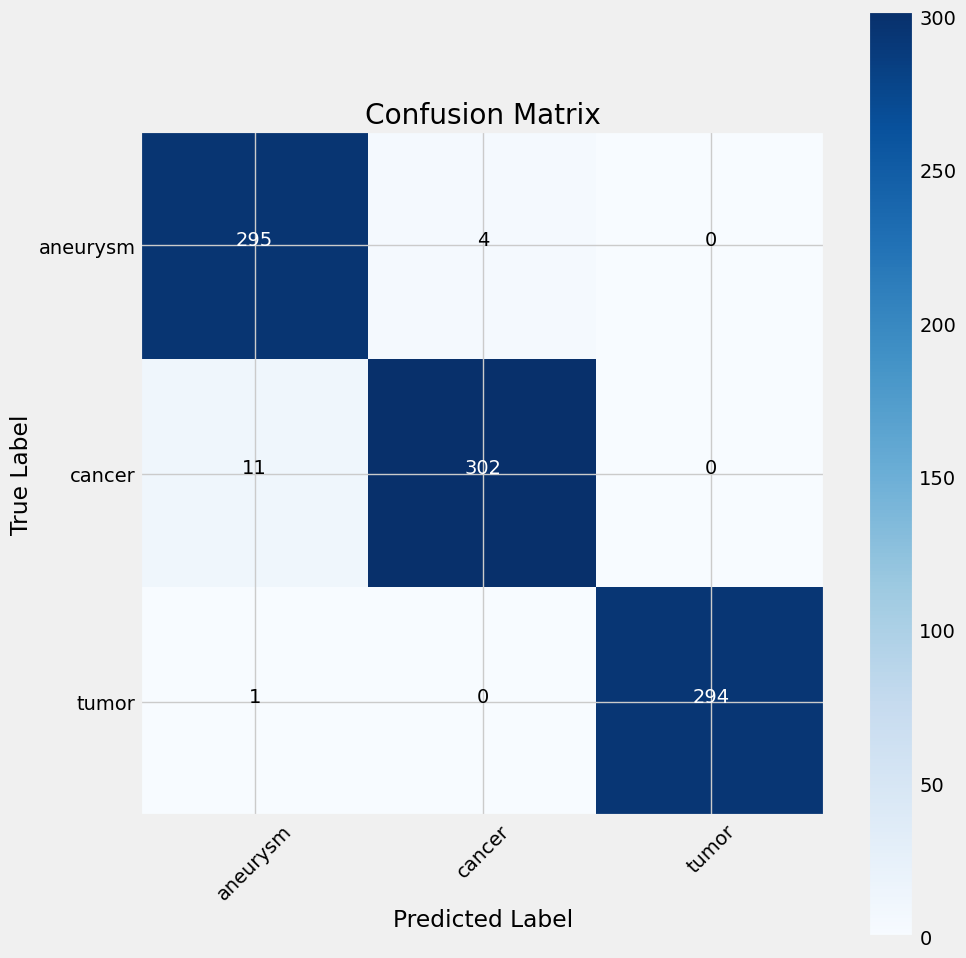

In [35]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

In [36]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    aneurysm       0.96      0.99      0.97       299
      cancer       0.99      0.96      0.98       313
       tumor       1.00      1.00      1.00       295

    accuracy                           0.98       907
   macro avg       0.98      0.98      0.98       907
weighted avg       0.98      0.98      0.98       907



## 3. EfficientNet-B7

In [37]:
from tensorflow.keras.applications import EfficientNetB7
tf.keras.backend.clear_session()

# Load the EfficientNetB7 model without the top (classification) layers
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling = 'max')


# Freeze the pre-trained layers
base_model.trainable = True

# Create a new model that includes the base_model
input_shape = (224, 224, 3)
efficientnet_model= tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (224,224, 3)),
#     tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    
    base_model,
    
    Dense(128, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),
    
    Dense(64, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(16, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(3, activation='softmax')
])

# Compile the model
efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(0.001),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)
efficientnet_model.summary()




258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [39]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [40]:
history3 = efficientnet_model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=2,
    callbacks=[early_stopping],
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=True
)

Epoch 1/90


W0000 00:00:1717345729.992106      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717345963.909430      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717345987.921635      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 - 533s - 11s/step - accuracy: 0.3713 - auc: 0.5517 - loss: 10.4893 - precision: 0.3797 - recall: 0.3179 - val_accuracy: 0.4109 - val_auc: 0.5707 - val_loss: 10.2553 - val_precision: 0.4286 - val_recall: 0.2791
Epoch 2/90
49/49 - 53s - 1s/step - accuracy: 0.4376 - auc: 0.6262 - loss: 10.2514 - precision: 0.4571 - recall: 0.3707 - val_accuracy: 0.4806 - val_auc: 0.6748 - val_loss: 9.9688 - val_precision: 0.5493 - val_recall: 0.3023
Epoch 3/90
49/49 - 51s - 1s/step - accuracy: 0.5283 - auc: 0.7139 - loss: 10.0346 - precision: 0.5635 - recall: 0.4743 - val_accuracy: 0.6822 - val_auc: 0.8461 - val_loss: 9.7121 - val_precision: 0.7250 - val_recall: 0.4496
Epoch 4/90
49/49 - 52s - 1s/step - accuracy: 0.5811 - auc: 0.7633 - loss: 9.8783 - precision: 0.6140 - recall: 0.5097 - val_accuracy: 0.6512 - val_auc: 0.8808 - val_loss: 9.6365 - val_precision: 0.8452 - val_recall: 0.5504
Epoch 5/90
49/49 - 52s - 1s/step - accuracy: 0.6178 - auc: 0.8059 - loss: 9.7558 - precision: 0.6497 - recall: 0.

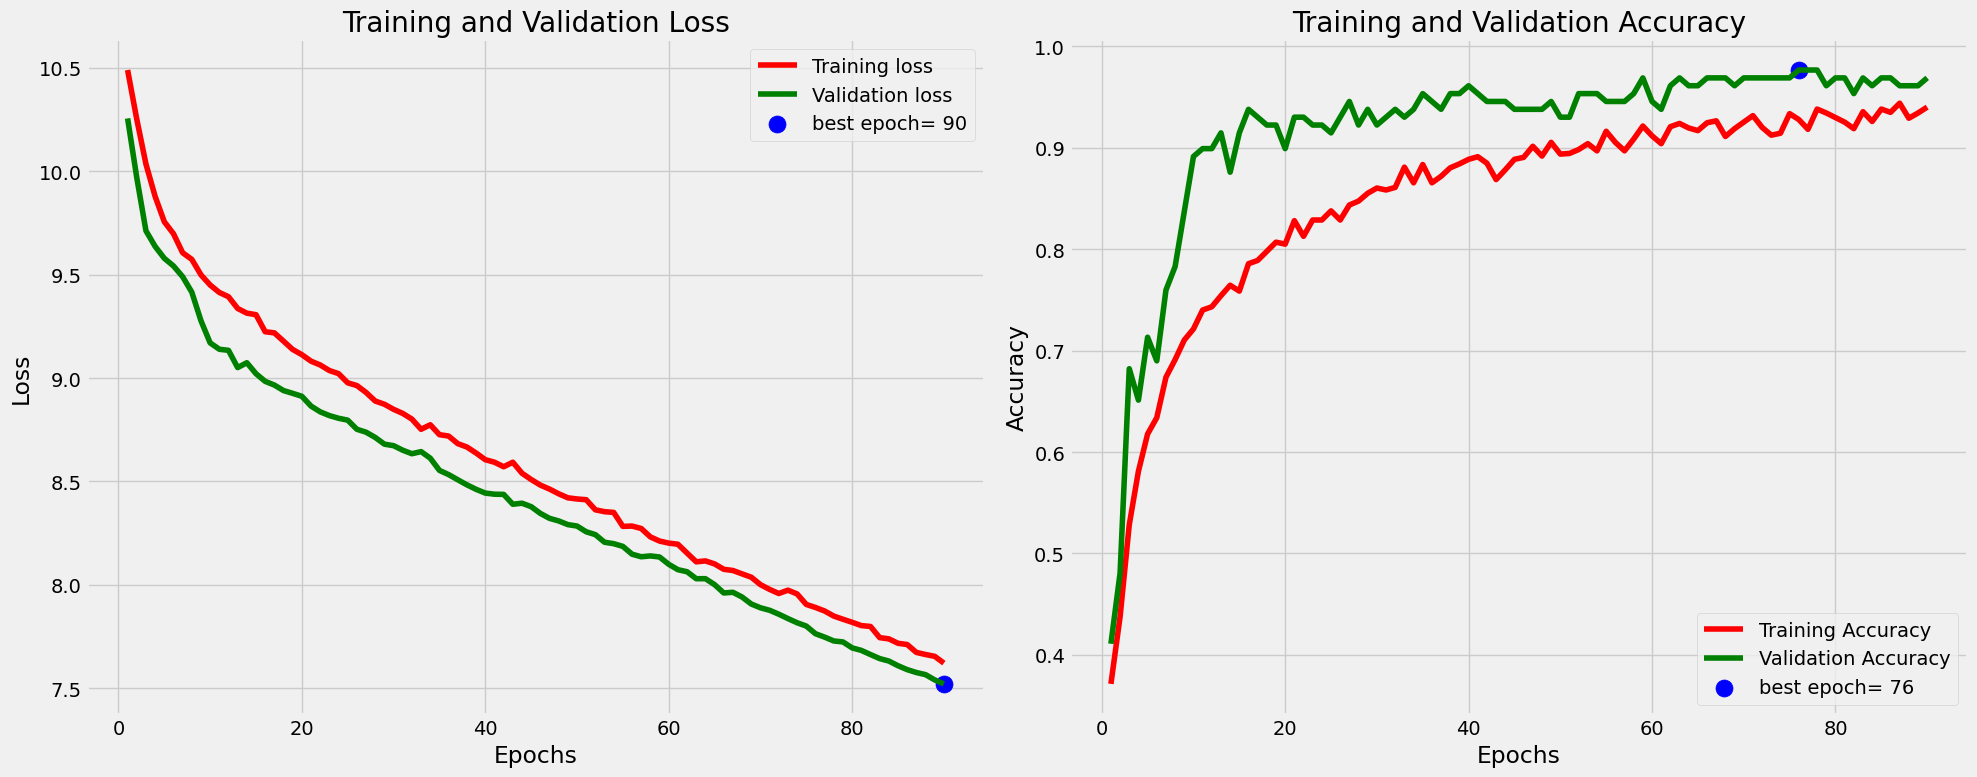

In [41]:
plot_training(history3)   

In [42]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = efficientnet_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = efficientnet_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = efficientnet_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

907/907 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.9930 - auc: 0.9999 - loss: 7.4707 - precision: 0.9930 - recall: 0.9930  


W0000 00:00:1717350731.408940      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - accuracy: 0.9690 - auc: 0.9986 - loss: 7.5211 - precision: 0.9843 - recall: 0.9690  
907/907 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9823 - auc: 0.9988 - loss: 7.4959 - precision: 0.9844 - recall: 0.9808
Train Loss:  7.4707350730896
Train Accuracy:  0.9929214715957642
--------------------
Validation Loss:  7.52120304107666
Validation Accuracy:  0.9689922332763672
--------------------
Test Loss:  7.505218505859375
Test Accuracy:  0.9757441878318787


In [43]:

preds = efficientnet_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)


907/907 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step
[1 1 1 1 0 1 0 0 0 1 2 2 2 2 2 2 2 0 1 0 1 2 2 2 0 1 0 1 1 2 2 2 1 0 2 0 2
 0 2 1 1 2 1 2 0 1 1 1 1 2 2 0 1 0 1 0 0 2 0 0 0 0 2 1 0 0 1 1 1 1 2 0 2 1
 1 1 0 0 1 0 2 0 0 1 0 0 1 1 2 1 1 2 0 1 1 2 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1
 1 2 2 1 0 0 1 2 2 2 2 2 0 1 2 1 1 2 2 0 2 2 2 0 1 0 0 1 0 0 2 1 2 2 2 1 0
 2 2 2 0 1 1 1 0 2 0 2 0 2 2 0 2 0 0 2 2 0 0 0 0 2 0 1 0 2 2 2 2 0 2 2 2 1
 2 2 1 0 1 0 2 0 0 2 0 1 1 0 0 2 2 2 2 0 1 0 1 1 1 2 1 2 0 2 1 1 0 2 2 0 1
 1 1 1 1 2 1 2 2 1 0 2 1 1 2 2 1 0 2 2 2 1 0 0 0 1 1 1 1 2 0 0 2 2 2 1 1 1
 0 1 0 0 0 2 1 0 1 1 1 2 0 0 1 1 1 2 0 0 1 1 1 0 1 2 1 0 2 0 0 0 1 0 1 2 0
 1 2 2 1 1 0 0 1 1 2 0 0 1 2 1 2 0 2 2 1 0 2 0 0 1 1 2 2 0 2 0 1 0 2 0 0 0
 1 0 0 1 2 1 0 0 2 0 2 2 2 0 2 2 0 0 2 0 1 2 0 0 2 2 1 1 1 0 1 1 0 2 0 0 2
 2 2 2 2 0 2 1 2 2 2 1 0 0 1 2 2 1 1 2 2 0 1 1 0 2 0 1 2 2 1 2 0 0 2 1 2 0
 1 1 2 2 0 0 2 2 0 1 1 1 1 2 2 0 1 0 2 2 2 2 2 1 2 1 0 0 0 1 1 1 2 0 2 2 2
 2 1 1 2 1 1 1 2 0 0 0 1 0 1 0 2 1 0 2 0 0 2 1 1 0 2 0 2 

Confusion Matrix, Without Normalization
[[293   6   0]
 [ 13 299   1]
 [  1   1 293]]


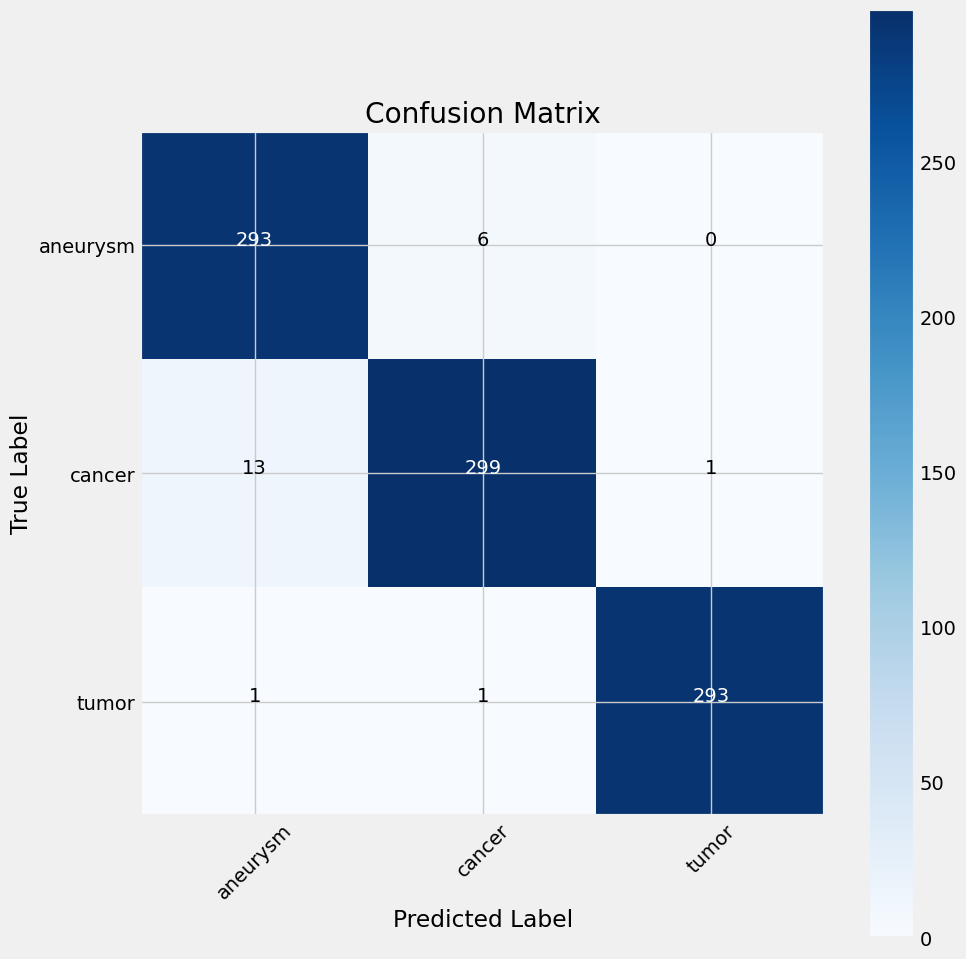

In [44]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

In [45]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    aneurysm       0.95      0.98      0.97       299
      cancer       0.98      0.96      0.97       313
       tumor       1.00      0.99      0.99       295

    accuracy                           0.98       907
   macro avg       0.98      0.98      0.98       907
weighted avg       0.98      0.98      0.98       907



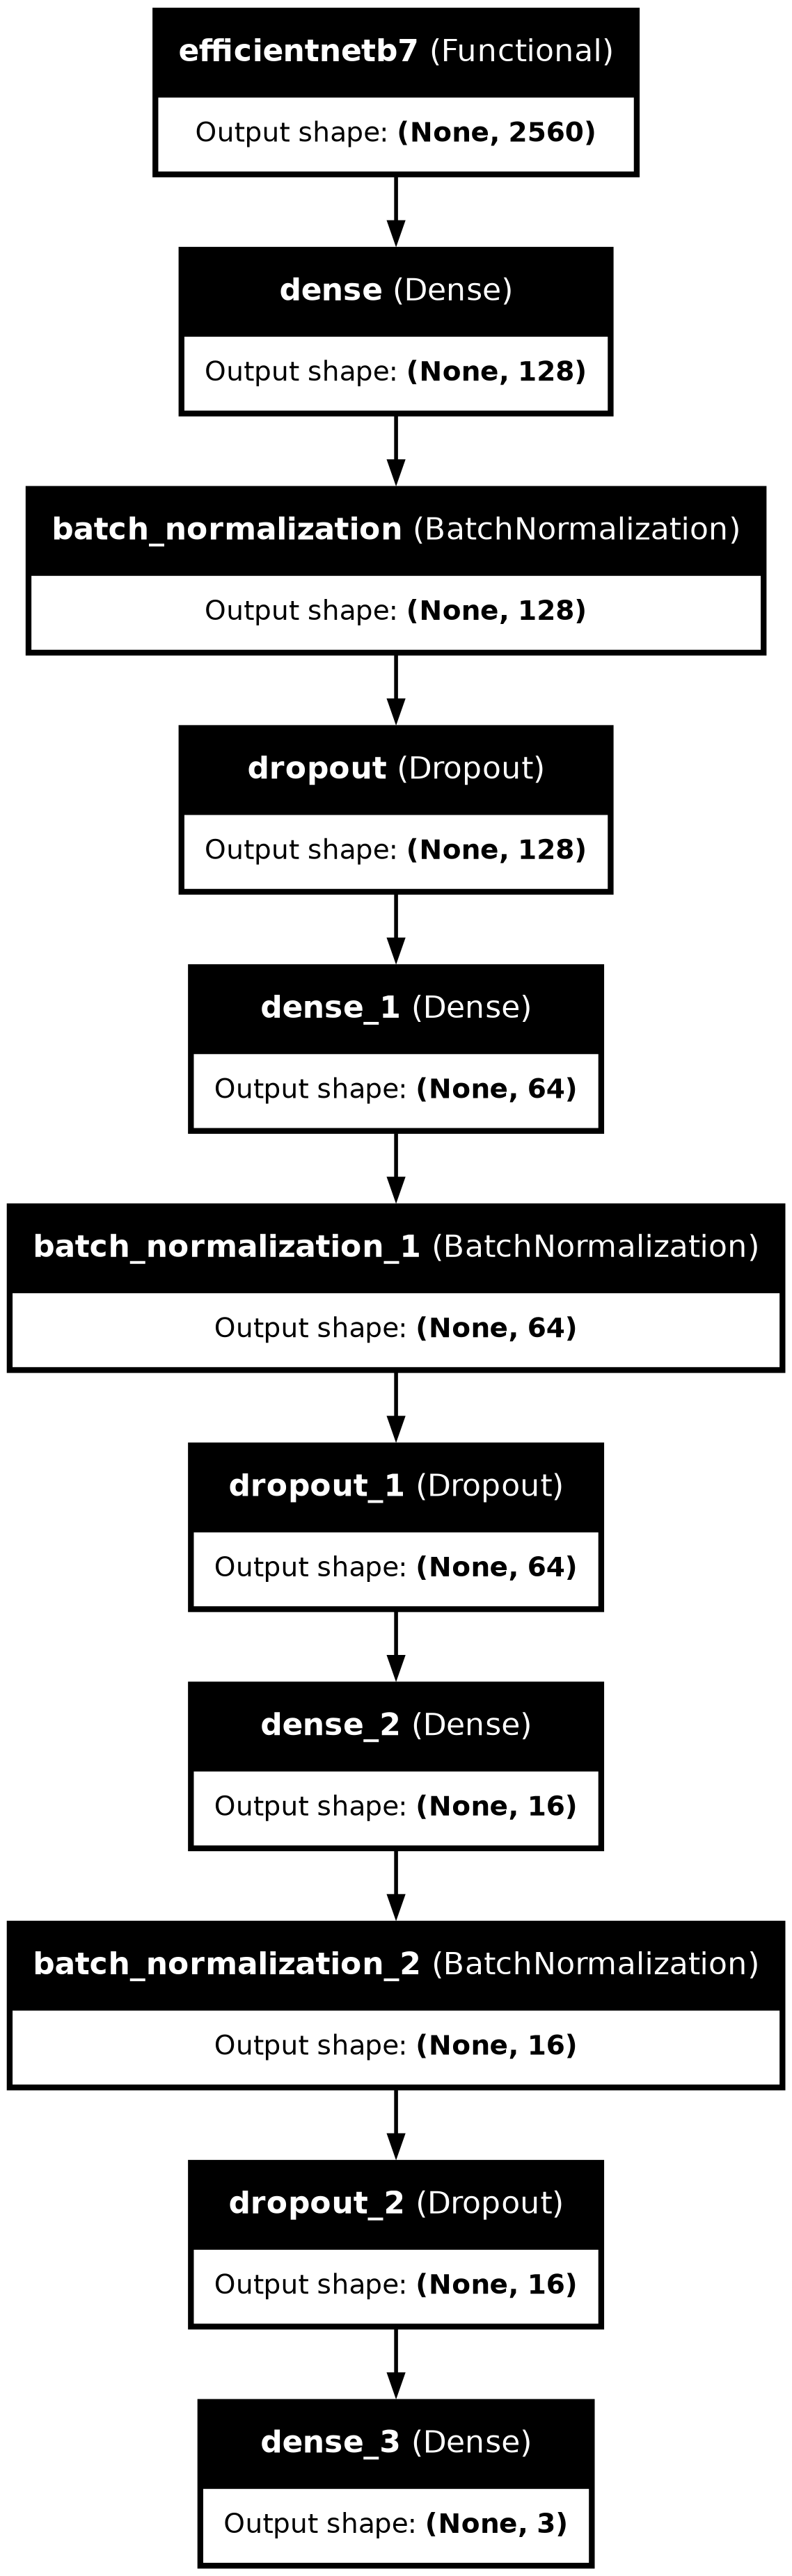

In [46]:

# Visualize the model architecture
plot_model(efficientnet_model, to_file='3rd-model_architecture.png', show_shapes=True, show_layer_names=True)